# Data Exploration Example in Python

- **Author**: Shania Braithwaite and PatentsView Team
- **Date**: February 2024


**Table of contents**<a id='toc0_'></a>    
- 1. [Overview](#toc1_)    
  - 1.1. [System Dependencies](#toc1_1_)    
- 2. [Initialize Local DuckDB Database](#toc2_)    
  - 2.1. [Download Bulk Data Files from PatentsView](#toc2_1_)    
  - 2.2. [Create/Connect to DuckDB Database](#toc2_2_)    
  - 2.3. [Create Tables in Database](#toc2_3_)    
- 3. [Prepare Data](#toc3_)    
  - 3.1. [Preview Tables](#toc3_1_)    
  - 3.2. [Joining Tables](#toc3_2_)    
- 4. [Analyzing Biotechnology Patents](#toc4_)    
  - 4.1. [IPC Codes](#toc4_1_)    
  - 4.2. [Trends Over Time](#toc4_2_)    
  - 4.3. [Assignee Types](#toc4_3_)    
  - 4.4. [U.S. Maps](#toc4_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Overview](#toc0_)

This notebook provides an example exploration of patents data using PatentsView's bulk data downloads, Python, and popular data science tools. It shows how to:

-  Download patent data tables from PatentsView.
-  Use DuckDB to efficiently parse, join, and query data that may not fit in memory.
-  Visualize a subset of the data using pandas and Plotly.

As a running example, we're looking into biotechnology patents identified via a subset of International Patent Classification (IPC) codes. Our goal is to explore the data, considering the distribution of biotechnology patent topic and the geographic distribution of biotechnology patent assignees.

### 1.1. <a id='toc1_1_'></a>[System Dependencies](#toc0_)

You can install required packages for running this notebook using:
```python
pip install duckdb pandas plotly kaleido ipywidgets
```

Alternatively, using [**conda**](https://docs.conda.io/projects/conda/en/latest/index.html), you can install the full reproducible environment specified in the repository's top-level `environment.yml` file:
```bash
conda env update -f environment.yml
conda activate pv-code-examples
```

## 2. <a id='toc2_'></a>[Initialize Local DuckDB Database](#toc0_)

First, we set up a local DuckDB database to help efficiently process larger-than-memory data.

### 2.1. <a id='toc2_1_'></a>[Download Bulk Data Files from PatentsView](#toc0_)

Download and unzip PatentsView tsv files. This may take a while depending on your internet connection:

In [1]:
from zipfile import ZipFile
from urllib.request import urlretrieve
import tempfile
import os


def extract_from_url(zipfile_url: str, filename: str, dir: str = ".", overwrite: bool = False):
    """
    Extract file from zipped download url.
    """
    filepath = os.path.join(dir, filename)
    if overwrite or not os.path.exists(filepath):
        with tempfile.NamedTemporaryFile() as zipped:
            urlretrieve(zipfile_url, zipped.name)
            with ZipFile(zipped) as zipfile:
                zipfile.extract(filename)

    return filepath

Download the tables we'll use:

In [2]:
tables = ["g_patent", "g_location_not_disambiguated", "g_assignee_not_disambiguated", "g_ipc_at_issue"]


def download_tables(tables):
    """
    Download and extract list of tables from PatentsView's bulk data downloads.
    """
    base_url = "https://s3.amazonaws.com/data.patentsview.org/download"
    for table in tables:
        download_url = f"{base_url}/{table}.tsv.zip"
        filename = f"{table}.tsv"
        extract_from_url(download_url, filename)


download_tables(tables)

### 2.2. <a id='toc2_2_'></a>[Create/Connect to DuckDB Database](#toc0_)

Initialize DuckDB database, or connect to it if it already exists:

In [3]:
import duckdb

con = duckdb.connect("patentsview.ddb")
con.execute("SET enable_progress_bar = false;")  # Avoid progress bar bugs on some systems.

### 2.3. <a id='toc2_3_'></a>[Create Tables in Database](#toc0_)

Next, read in the PatentsView tsv files that we previously downloaded and save them to the database:

In [4]:
def list_tables(con: duckdb.DuckDBPyConnection):
    """
    Returns list of table names in database.
    """
    return [row[0] for row in con.execute("show tables").fetchall()]


def create_tables_if_not_exist(con, tables):
    """
    Create DuckDB database tables from tsv files.
    """
    for table in tables:
        if table not in list_tables(con):
            con.read_csv(f"{table}.tsv", delimiter="\t", quotechar='"', escapechar='"', all_varchar=True).create(table)


create_tables_if_not_exist(con, tables)

## 3. <a id='toc3_'></a>[Prepare Data](#toc0_)

With the data loaded in our local DuckDB database, we can now preview and prepare the data.

### 3.1. <a id='toc3_1_'></a>[Preview Tables](#toc0_)

Retrieve handles to our database tables:

In [5]:
g_patent = con.table("g_patent")
g_location_not_disambiguated = con.table("g_location_not_disambiguated")
g_assignee_not_disambiguated = con.table("g_assignee_not_disambiguated")
g_ipc_at_issue = con.table("g_ipc_at_issue")

Preview `g_patent`, the table with patent grant date and the patent title:

In [7]:
g_patent.limit(2).df()

,patent_id,patent_type,patent_date,patent_title,wipo_kind,num_claims,withdrawn,filename
0,10000000,utility,2018-06-19,Coherent LADAR using intra-pixel quadrature de...,B2,20,0,ipg180619.xml
1,10000001,utility,2018-06-19,Injection molding machine and mold thickness c...,B2,12,0,ipg180619.xml


Preview `g_location_not_disambiguated`, the table with location information. This will be later joined with the assignee table:

In [8]:
g_location_not_disambiguated.limit(2).df()

,rawlocation_id,location_id,raw_city,raw_state,raw_country
0,000005mtrirpdyrtlkfbffj0e,1d2251c8-16c8-11ed-9b5f-1234bde3cd05,Kanagawa,None,JP
1,00006fjnoq057no2s4bse374r,439af3dd-16c8-11ed-9b5f-1234bde3cd05,Dallas,TX,US


Preview `g_assignee_not_disambiguated`, the table with information for all patent assignees. Each row is an assignee, and there may be more than one assignee per patent.

In [9]:
g_assignee_not_disambiguated.limit(2).df()

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id
0,4488683,0,b12aba35-6fdd-4346-b7c0-8c7a157c8844,None,None,Metal Works Ramat David,3,b44f6bf0-1f14-4b25-9ab6-06945ff1e8e1
1,11872626,0,ee0744f6-d2d4-46f4-8be7-2758e096a6a9,None,None,"DIVERGENT TECHNOLOGIES, INC.",2,8zd6qm7aatxho9jcoihh78un1


Preview `g_ipc_at_issue`, the table with International Patent Classification (IPC) codes for all patents. Each row is a single IPC code, as it appears on the original patent grant publication. There are typically multiple IPC codes per patent.

In [10]:
g_ipc_at_issue.limit(2).df()

,patent_id,ipc_sequence,classification_level,section,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator
0,6864832,0,None,G,01,S,013,/42,None,None,None,None,None
1,9954111,8,A,H,01,L,27,1156,I,B,H,2018-04-24,2017-01-01


### 3.2. <a id='toc3_2_'></a>[Joining Tables](#toc0_)

Now we join all tables together, as to have all of the information about patents, patent assignees, and IPC codes together. This results in a table with one row for each combination of patent, assignee, and IPC code in the data.

In [12]:
patent_joined = (
    g_patent.join(g_assignee_not_disambiguated, "patent_id", how="left")
    .join(g_location_not_disambiguated, "rawlocation_id", how="left")
    .join(g_ipc_at_issue, "patent_id", how="left")
)

patent_joined.limit(1).df().columns

Index(['patent_id', 'patent_type', 'patent_date', 'patent_title', 'wipo_kind',
       'num_claims', 'withdrawn', 'filename', 'assignee_sequence',
       'assignee_id', 'raw_assignee_individual_name_first',
       'raw_assignee_individual_name_last', 'raw_assignee_organization',
       'assignee_type', 'rawlocation_id', 'location_id', 'raw_city',
       'raw_state', 'raw_country', 'ipc_sequence', 'classification_level',
       'section', 'ipc_class', 'subclass', 'main_group', 'subgroup',
       'classification_value', 'classification_status',
       'classification_data_source', 'action_date', 'ipc_version_indicator'],
      dtype='object')

There are 25804807 rows in the dataset, many more than the number of patents (around 9 millions at the time of writing). 

In [13]:
len(patent_joined)

25804807

## 4. <a id='toc4_'></a>[Analyzing Biotechnology Patents](#toc0_)

In [14]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_white"
pio.renderers["png"].scale = 4

### 4.1. <a id='toc4_1_'></a>[IPC Codes](#toc0_)

We consider this subset of biotechnology classification codes:

In [15]:
# Define criteria for the biotechnology IPC sections, classes, and subclasses
ipc_to_biotech = {
    "C07G": "Pharmaceuticals",
    "C12N": "Genetic Engineering",
    "C12Q": "Diagnostics & Biotechnology Tools",
    "C12P": "Industrial Biotechnology",
    "C07K": "Biopharmaceuticals",
    "C12M": "Biotechnology Instruments",
    "C40B": "Combinatorial Chemistry & Drug Discovery",
}

Here we filter the data to only patents that contain these codes, and we only keep the **first assignee** from each patent. This results in a table with one row per combination of patent and IPC code in the list above.

In [16]:
bt_pat_first_asgn_x_ipc = (
    patent_joined.query("_", "select *, section||ipc_class||subclass as biotech_code from _")
    .filter(f"biotech_code in {list(ipc_to_biotech.keys())}")
    .order("assignee_sequence ASC")
    .aggregate(
        ",".join(f"first({col}) as {col}" for col in patent_joined.columns + ["biotech_code"]),
        group_expr="patent_id, biotech_code",
    )
    .fetchdf()
)

bt_pat_first_asgn_x_ipc.head(2)

,patent_id,patent_type,patent_date,patent_title,wipo_kind,num_claims,withdrawn,filename,assignee_sequence,assignee_id,...,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator,biotech_code
0,8563307,utility,2013-10-22,Treatment of immunosuppression-related disorders,B2,9,0,ipg131022.xml,None,None,...,12,N,5,08,I,B,H,2013-10-22,2006-01-01,C12N
1,8592661,utility,2013-11-26,Citrus cultivar CALLOR1,B1,21,0,ipg131126.xml,None,None,...,12,N,15,82,I,B,H,2013-11-26,2006-01-01,C12N


Add the full IPC code description to the data:

In [18]:
biotech_fields = bt_pat_first_asgn_x_ipc["biotech_code"].map(ipc_to_biotech)
bt_pat_first_asgn_x_ipc["biotech_field"] = biotech_fields

Visualize the number of patents that include each of the given IPC codes. Note that a single patent may be counted multiple times, as it can include multiple IPC codes:

In [21]:
fig = px.histogram(
    bt_pat_first_asgn_x_ipc,
    x="biotech_field",
    title="Patent Counts for Selected Biotechnology Sectors",
    subtitle="Counts of patents granted between 1975 and September 30, 2024, and that include the given IPC classification code.",
    labels={"biotech_field": "Biotechnology Field", "count": "Number of Patents"},
    text_auto=True,
)
fig.update_xaxes(categoryorder="total descending")
fig.update_yaxes(title="Patent Count")

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### 4.2. <a id='toc4_2_'></a>[Trends Over Time](#toc0_)

Visualize trend over time of the utilization of the given IPC codes. Note that the IPC classification has evolved over time. As such, this trend may not be directly representative of underlying patenting topic activity. It only represents IPC code utilization trends.

In [17]:
bt_pat_first_asgn_x_ipc["year"] = pd.to_datetime(bt_pat_first_asgn_x_ipc["patent_date"]).dt.year
df = bt_pat_first_asgn_x_ipc.groupby(["year", "biotech_field"]).size().reset_index(name="count")

px.line(
    df,
    x="year",
    y="count",
    color="biotech_field",
    markers=True,
    title="Biotech Patent Trends Over Time",
    labels={"year": "Year", "count": "Patent Count", "biotech_field": "Biotech Field"},
)

### 4.3. <a id='toc4_3_'></a>[Assignee Types](#toc0_)

Next we look at assignee types, such as private or governmental organizations. The classification of assignees is: 1 - Unassigned, 2 - US Company or Corporation, 3 - Foreign Company or Corporation, 4 - US Individual, 5 - Foreign Individual, 6 - US Federal Government, 7 - Foreign Government, 8 - US County Government, 9 - US State Government. Note: A "1" appearing before any of these codes signifies part interest.

Our data was previously disaggregated by IPC code. Here we keep one row per patent, and only consider the first assignee listed on the patent.

In [18]:
bt_pat_first_asgn = bt_pat_first_asgn_x_ipc.groupby("patent_id").agg("first")
bt_pat_first_asgn.head(2)

,patent_type,patent_date,patent_title,wipo_kind,num_claims,withdrawn,filename,assignee_sequence,assignee_id,raw_assignee_individual_name_first,...,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator,biotech_code,biotech_field,year
patent_id,,,,,,,,,,,,,,,,,,,,,
10000402,utility,2018-06-19,Producing algal biomass and products from orga...,B2,16,0,ipg180619.xml,0,d3e021bb-8fba-4cf5-bb29-b7d5b7dff01c,None,...,1,12,I,B,H,2018-06-19,2006-01-01,C12N,Genetic Engineering,2018
10000429,utility,2018-06-19,Method and apparatus for operating a composter...,B2,13,0,ipg180619.xml,0,227cff38-44c5-42d6-9df3-01393be625cb,None,...,1,0,I,B,H,2018-06-19,2006-01-01,C12M,Biotechnology Instruments,2018


Add long form assignee type description to the data:

In [19]:
assignee_types = {
    "1": "Unassigned",
    "2": "US Company",
    "3": "Foreign Company",
    "4": "US Individual",
    "5": "Foreign Individual",
    "6": "US Federal Govt",
    "7": "Foreign Govt",
    "8": "US County Govt",
    "9": "US State Govt",
}
assignee_types.update({"1" + code: label + " (part interest)" for code, label in assignee_types.items()})

View table of patent count per assignee type, for patents with the given biotechnology IPC codes:

In [20]:
bt_pat_first_asgn["assignee_label"] = bt_pat_first_asgn["assignee_type"].map(assignee_types)
(bt_pat_first_asgn.groupby(["assignee_label"]).size().reset_index(name="count").sort_values("count", ascending=False))

,assignee_label,count
6,US Company,125397
0,Foreign Company,76592
9,US Federal Govt,3358
2,Foreign Govt,946
4,Foreign Individual,875
10,US Individual,404
12,US State Govt,85
7,US Company (part interest),10
1,Foreign Company (part interest),8
11,US Individual (part interest),4


### 4.4. <a id='toc4_4_'></a>[U.S. Maps](#toc0_)

Next map the distribution of assignee location in the United States, for the biotechnology patents with the given IPC codes.

Add long form state names to the data:

In [21]:
state_abbreviation_to_name = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming",
}
assert len(state_abbreviation_to_name.keys()) == 50

US_biotech_patents = bt_pat_first_asgn.loc[bt_pat_first_asgn["raw_country"] == "US"].copy()
US_biotech_patents["assignee_state_name"] = US_biotech_patents["raw_state"].map(state_abbreviation_to_name)

state_counts = US_biotech_patents.groupby(["assignee_state_name", "raw_state"]).size().reset_index(name="patent_count")

state_counts.sort_values("patent_count", ascending=False).head()

,assignee_state_name,raw_state,patent_count
4,California,CA,34958
20,Massachusetts,MA,13963
31,New York,NY,8962
29,New Jersey,NJ,6974
24,Missouri,MO,5395


Create map:

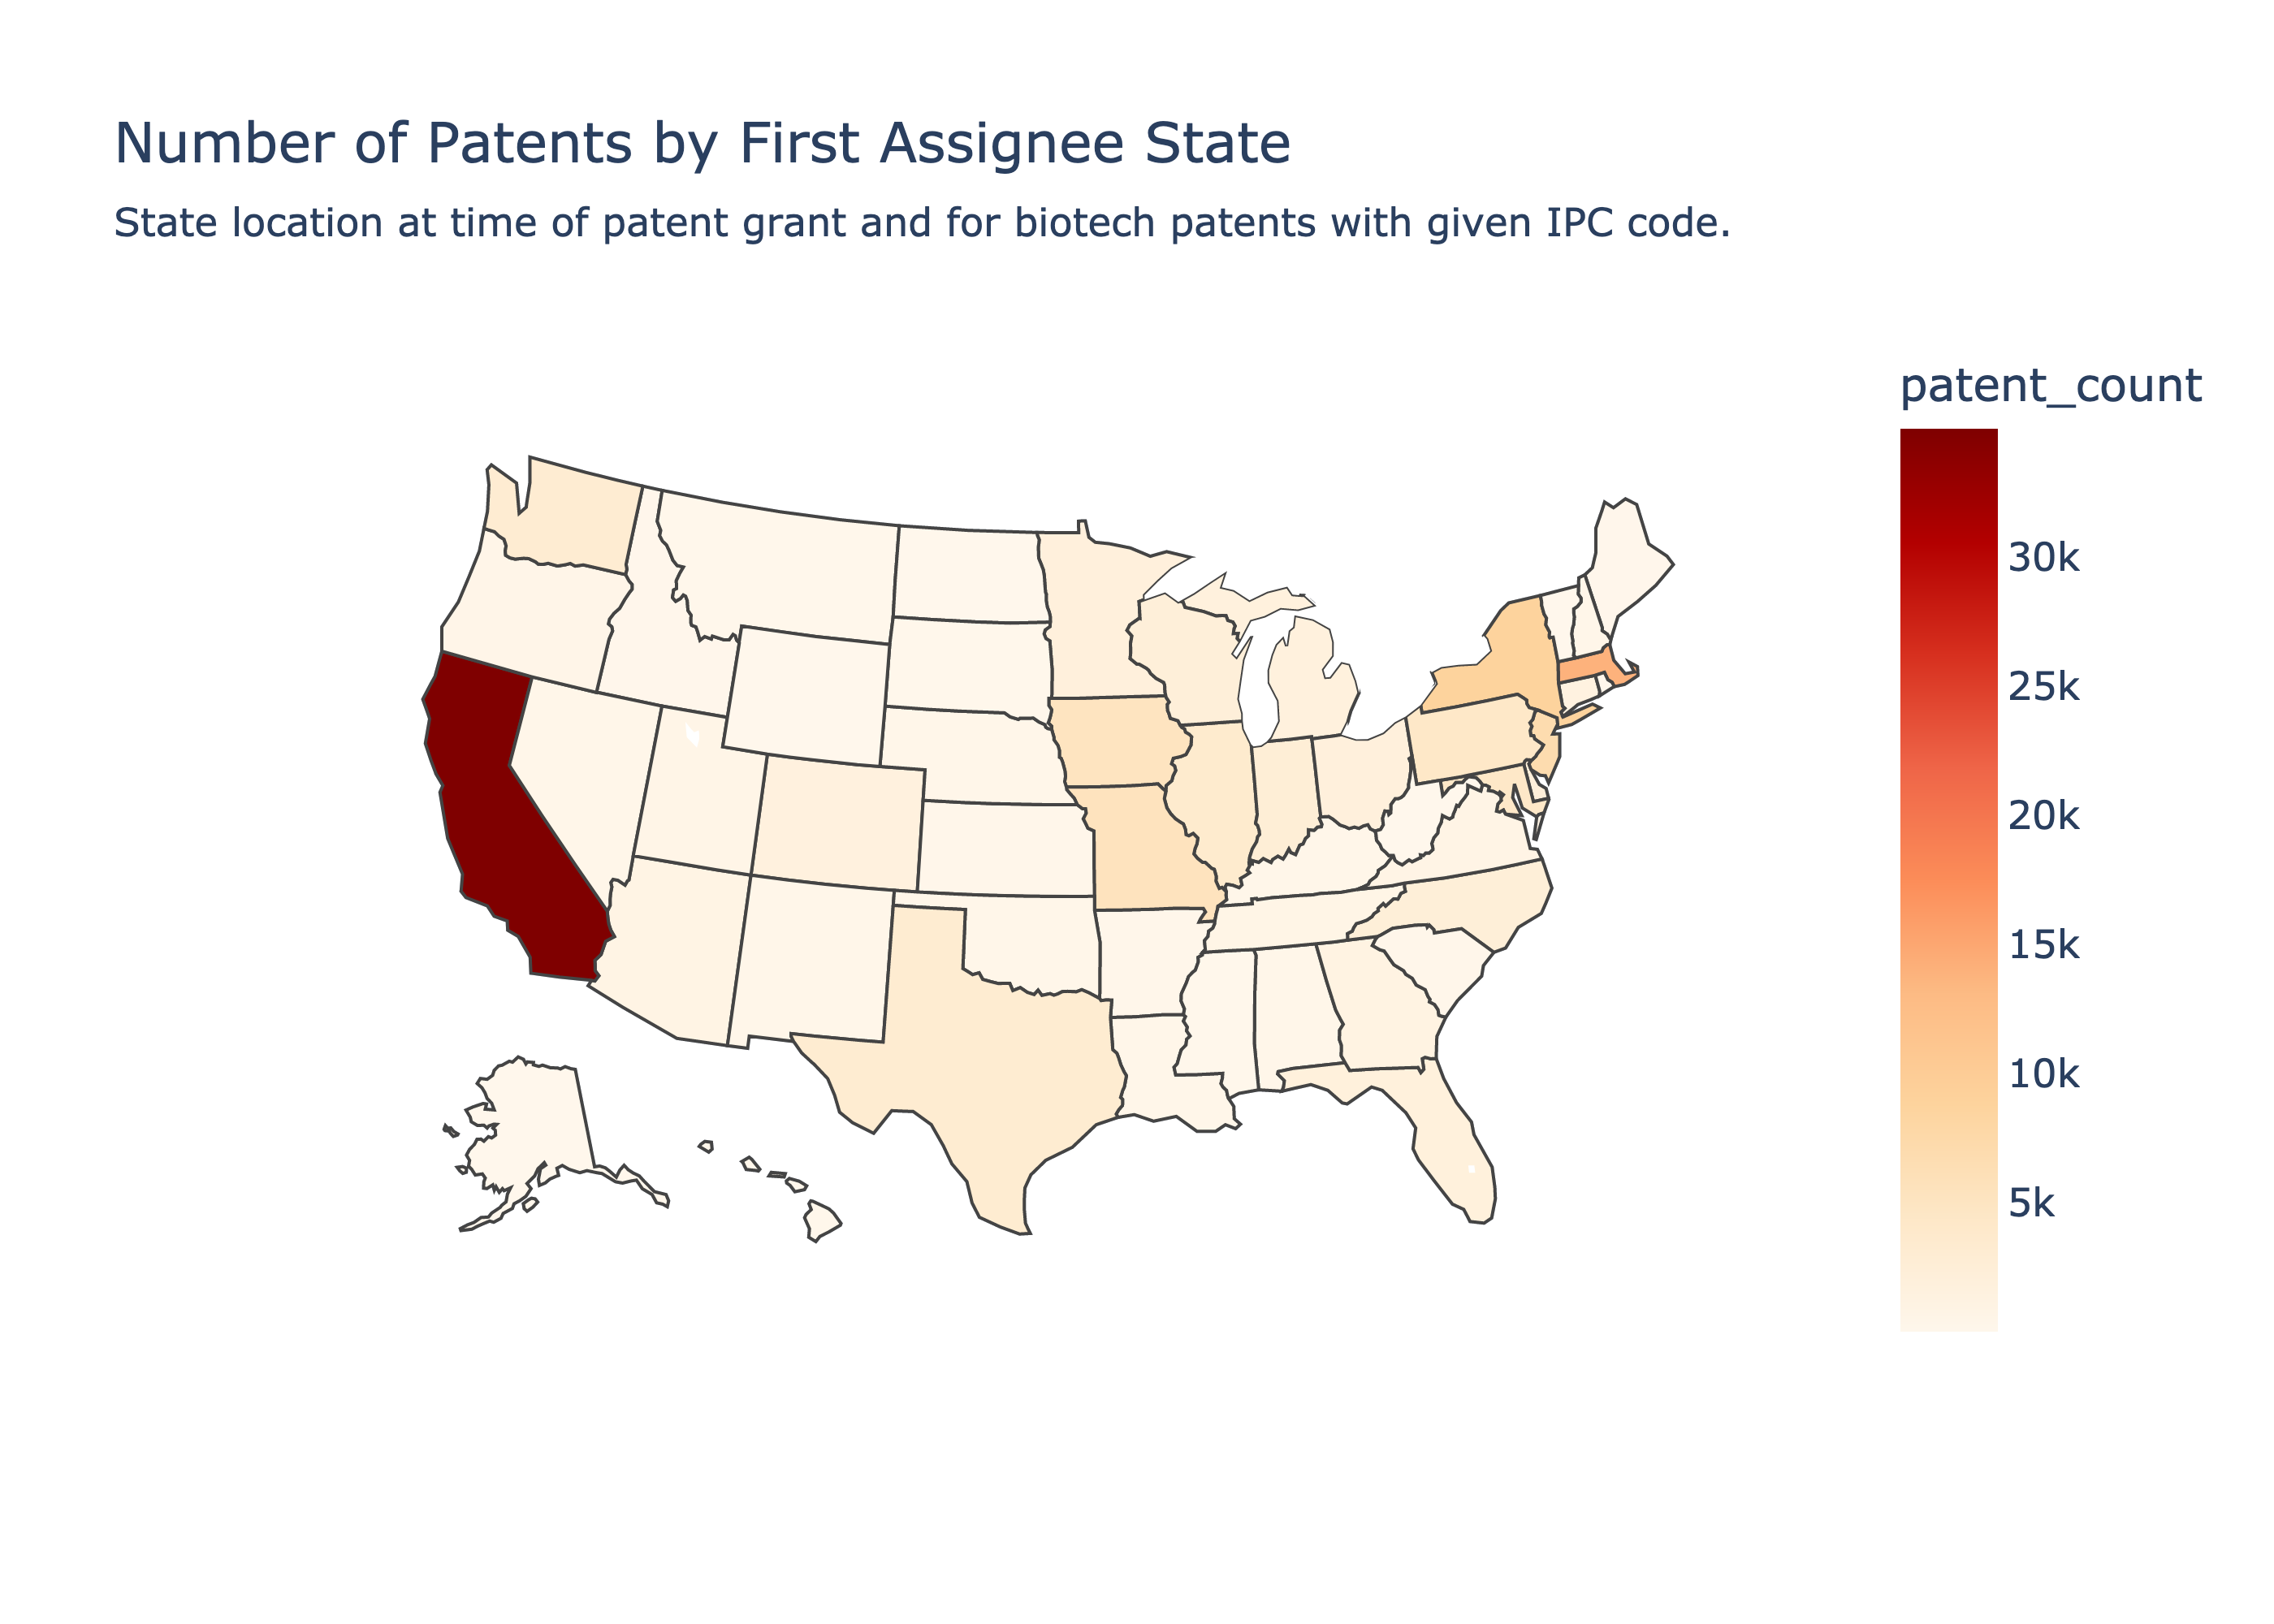

In [22]:
fig = px.choropleth(
    state_counts,
    locations="raw_state",
    locationmode="USA-states",
    color="patent_count",
    hover_name="assignee_state_name",
    color_continuous_scale="OrRd",
    scope="usa",
    title="Number of Patents by First Assignee State",
    subtitle="State location at time of patent grant and for biotech patents with given IPC code."
)

fig.show(renderer="png")

We also consider the number of patents per thousand residents. For this, we use the Census Bureau State population estimates from https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html

In [23]:
state_population = pd.read_csv("resources/NST-EST2024-POP-extract.csv")
state_population.head()

,State,2024
0,Alabama,5157699
1,Alaska,740133
2,Arizona,7582384
3,Arkansas,3088354
4,California,39431263


Join the state population data and compute patent count per thousand resident:

In [24]:
rel_state_counts = state_counts.merge(
    state_population, how="left", left_on="assignee_state_name", right_on="State", validate="1:1"
)

rel_state_counts["count_per_thousand"] = 1000 * rel_state_counts["patent_count"] / rel_state_counts["2024"]

rel_state_counts.head()

,assignee_state_name,raw_state,patent_count,State,2024,count_per_thousand
0,Alabama,AL,403,Alabama,5157699,0.078136
1,Alaska,AK,22,Alaska,740133,0.029724
2,Arizona,AZ,1009,Arizona,7582384,0.133072
3,Arkansas,AR,252,Arkansas,3088354,0.081597
4,California,CA,34958,California,39431263,0.886555


View the result as a map:

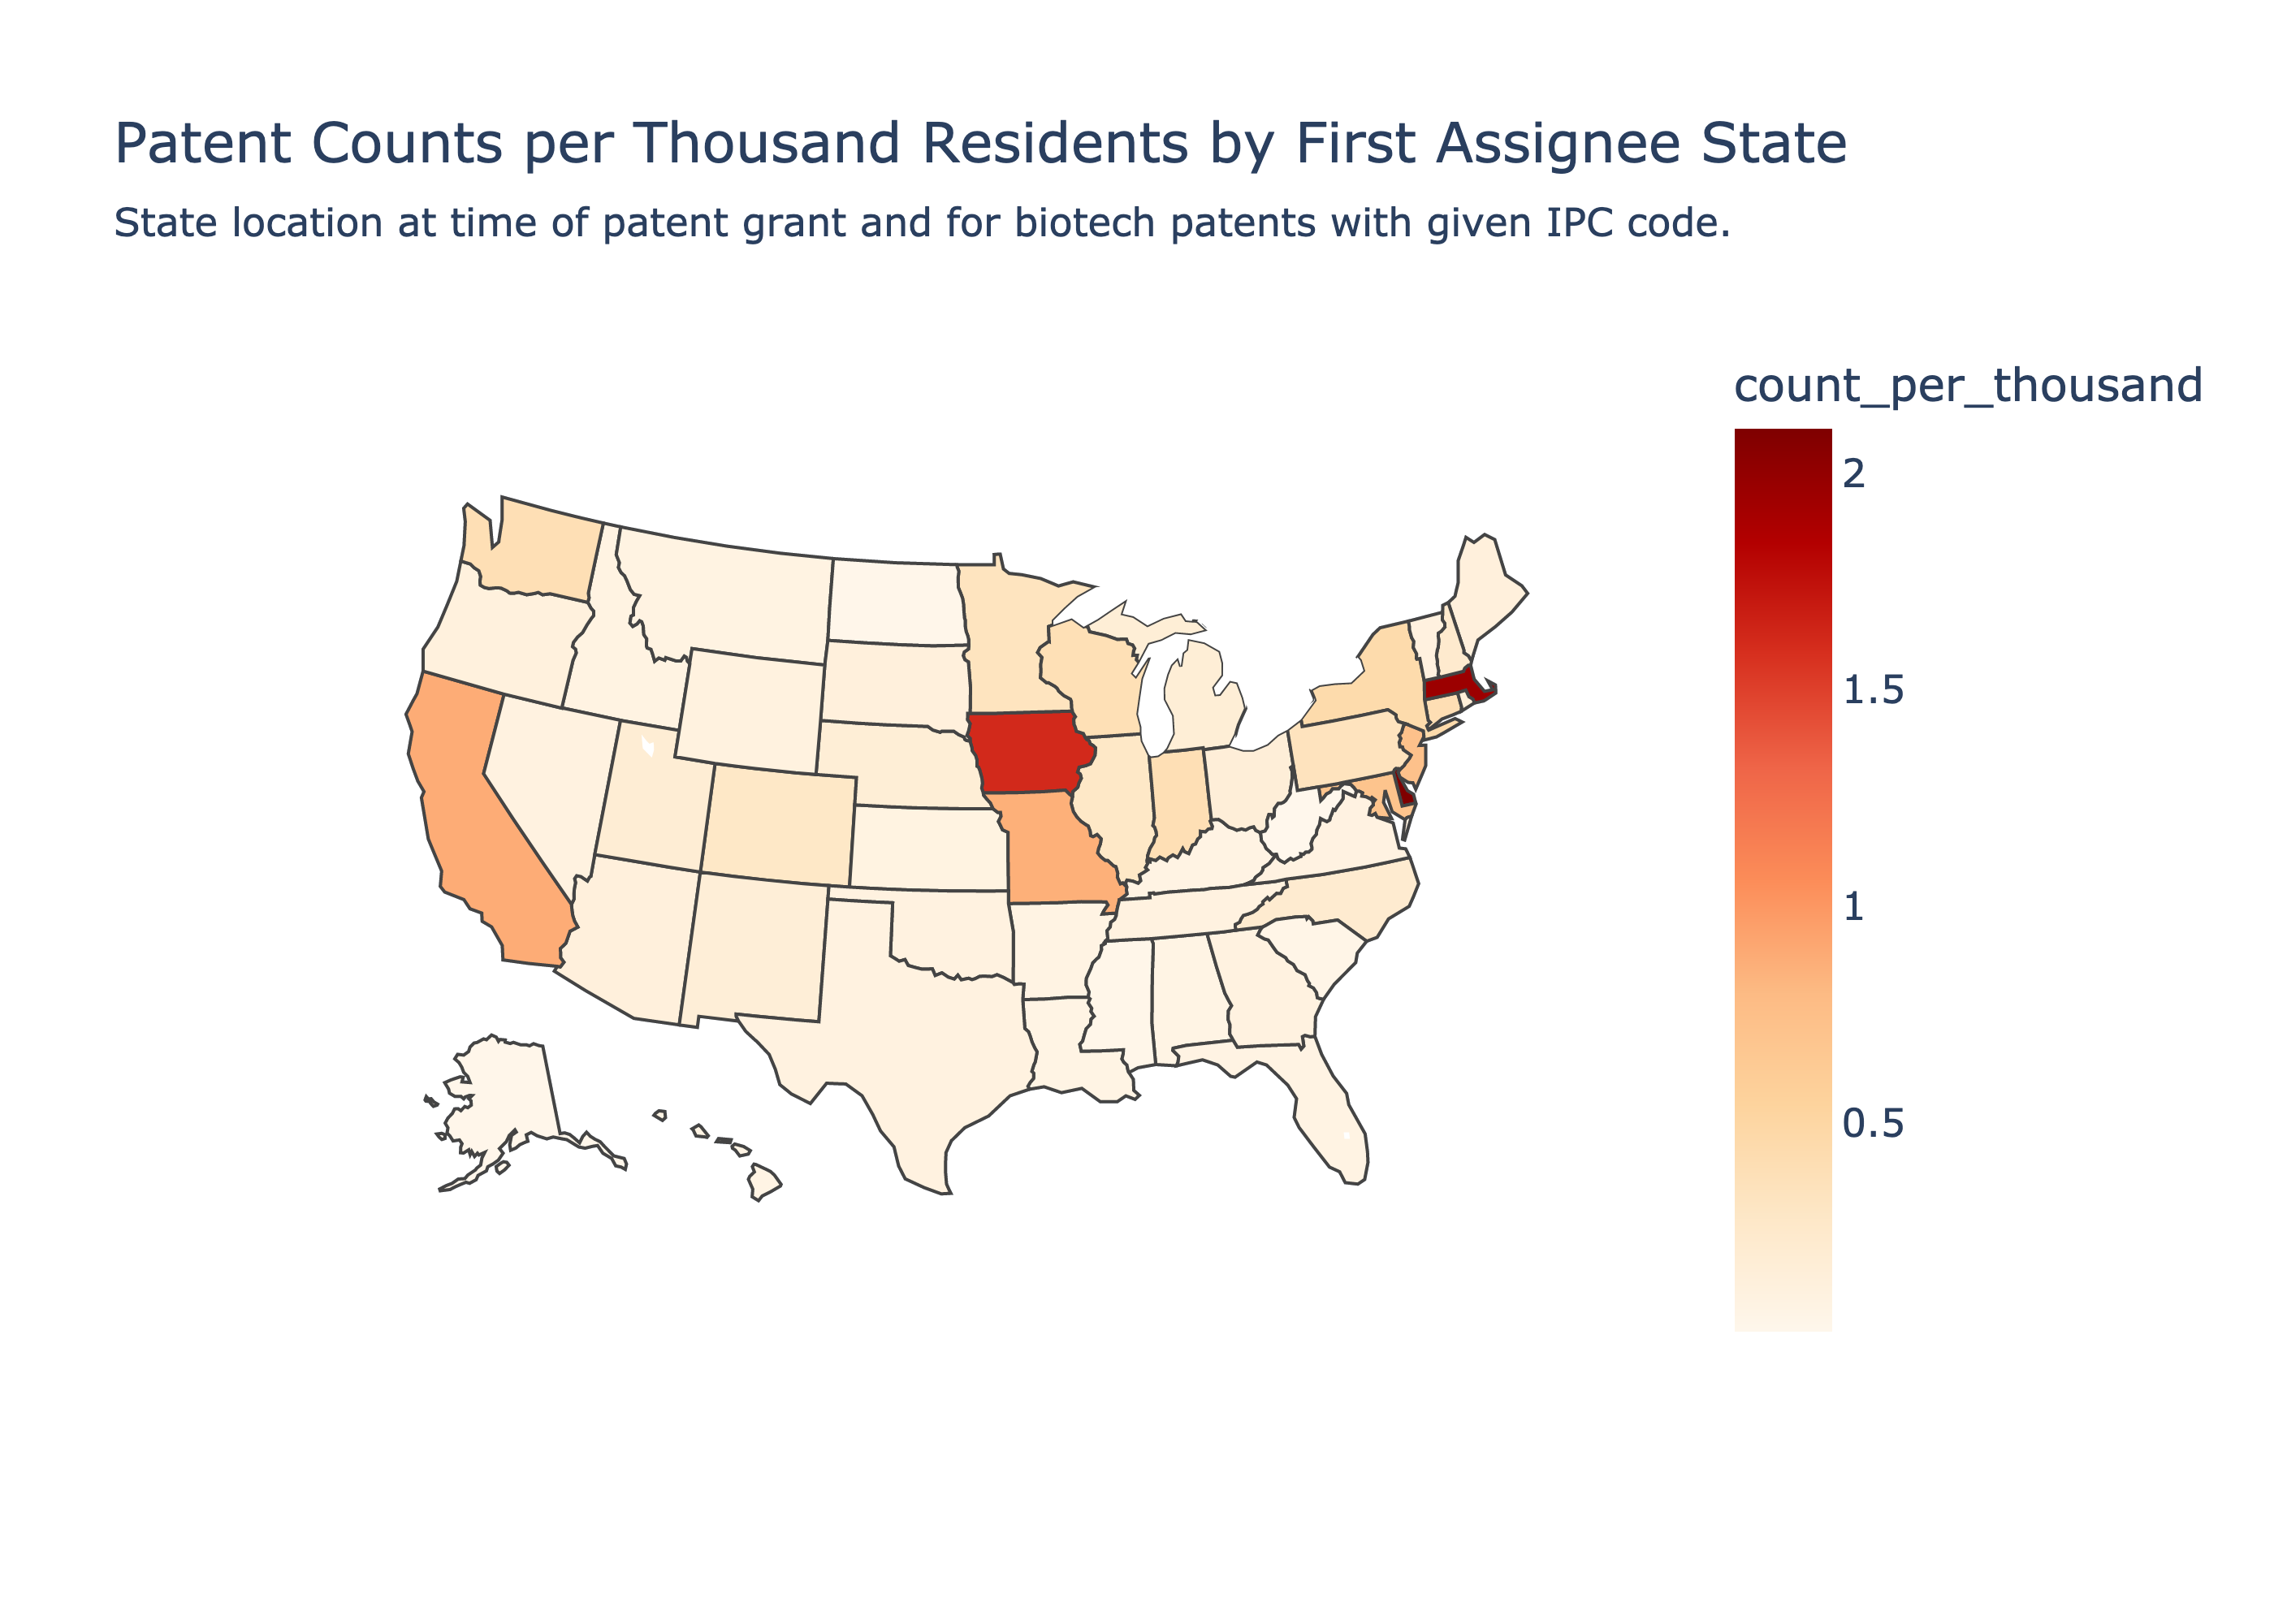

In [25]:
fig = px.choropleth(
    rel_state_counts,
    locations="raw_state",
    locationmode="USA-states",
    color="count_per_thousand",
    hover_name="assignee_state_name",
    color_continuous_scale="OrRd",
    scope="usa",
    title=f"Patent Counts per Thousand Residents by First Assignee State",
    subtitle="State location at time of patent grant and for biotech patents with given IPC code."
)

fig.show(renderer="png")